In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()


In [2]:
from datetime import datetime, time
#import pandas_datareader.data as pdr
import pandas_datareader.data as pdr
import yfinance as yf

In [3]:
#Download historical stock data
ticker_symbol = 'AAPL'
stock_data = yf.download(tickers= ticker_symbol, start= '2010-01-01', end= '2025-01-01')
print(stock_data.head())

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Price          Close      High       Low      Open     Volume
Ticker          AAPL      AAPL      AAPL      AAPL       AAPL
Date                                                         
2010-01-04  6.440330  6.455075  6.391277  6.422875  493729600
2010-01-05  6.451466  6.487879  6.417459  6.458086  601904800
2010-01-06  6.348848  6.477047  6.342228  6.451467  552160000
2010-01-07  6.337110  6.379843  6.291067  6.372319  477131200
2010-01-08  6.379241  6.379844  6.291369  6.328684  447610800


Another methods for data extraction

In [4]:
today = datetime.now().date()
five_year_ago = today.replace(year = today.year-5)
ten_year_ago = today.replace(year = today.year-10)
twenty_year_ago = today.replace(year= today.year-20)
stock_symbol = "AAPL"
try:
    data =yf.download(stock_symbol, start=ten_year_ago, end=today, rounding=True,multi_level_index=False)
    print(data.head())
except Exception as e:
    print(f"Error: {e}")

[*********************100%***********************]  1 of 1 completed

            Close   High    Low   Open     Volume
Date                                             
2015-04-20  28.50  28.61  27.95  28.04  188217200
2015-04-21  28.34  28.63  28.29  28.61  129740400
2015-04-22  28.72  28.78  28.21  28.36  150618000
2015-04-23  28.96  29.13  28.62  28.65  183083600
2015-04-24  29.10  29.17  28.86  29.14  178103600


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2015-04-20 to 2025-04-17
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   2516 non-null   float64
 1   High    2516 non-null   float64
 2   Low     2516 non-null   float64
 3   Open    2516 non-null   float64
 4   Volume  2516 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 117.9 KB


Test for Normality

In [6]:
from scipy.stats import jarque_bera

jb_stat, jb_p = jarque_bera(data['Close'])

print("Jarque-Bera statistic :", jb_stat)
print("p-value:", jb_p)

if jb_p < 0.05:
    print("the dataset is not normally distributed")
else:
    print("the dataset is normally distributed")


Jarque-Bera statistic : 229.5967711777502
p-value: 1.3921774898042438e-50
the dataset is not normally distributed


Test for Autocorrelation

In [7]:
from statsmodels.stats.diagnostic import acorr_ljungbox

def ljungbox_test(data, lags_list=[5,10]):
    for lag in lags_list:
        lb_test = acorr_ljungbox(data, lags= lags_list, return_df=True)

        p_value = lb_test['lb_pvalue'].iloc[0]

        if p_value > 0.05:
            interpretation = f"Fail to reject the null hypothesis at lag {lag}: No significance autocorrelation."
        else:
            interpretation = f"Reject null hypothesis at lag {lag}: Significant autocorrelation present"

        print(f"Ljung-Box test p-value for lag {lag}: {p_value:.5f}")
        print(f"Interpretation: {interpretation}")
        print()

ljungbox_test(data['Close'])

Ljung-Box test p-value for lag 5: 0.00000
Interpretation: Reject null hypothesis at lag 5: Significant autocorrelation present

Ljung-Box test p-value for lag 10: 0.00000
Interpretation: Reject null hypothesis at lag 10: Significant autocorrelation present



Exploratory data analysis

In [8]:
import plotly.express as px


In [9]:
fig = px.line(data, x=data.index, y ='Close', title=f'The close price of stock {ticker_symbol}',
              labels={'Close':'Close_price$'},
              template='plotly', width=1000, height=600)
fig.update_traces(line_color = 'black')
fig.update_layout(title_font_color = 'blue', title_font_size = 20)
fig.show()

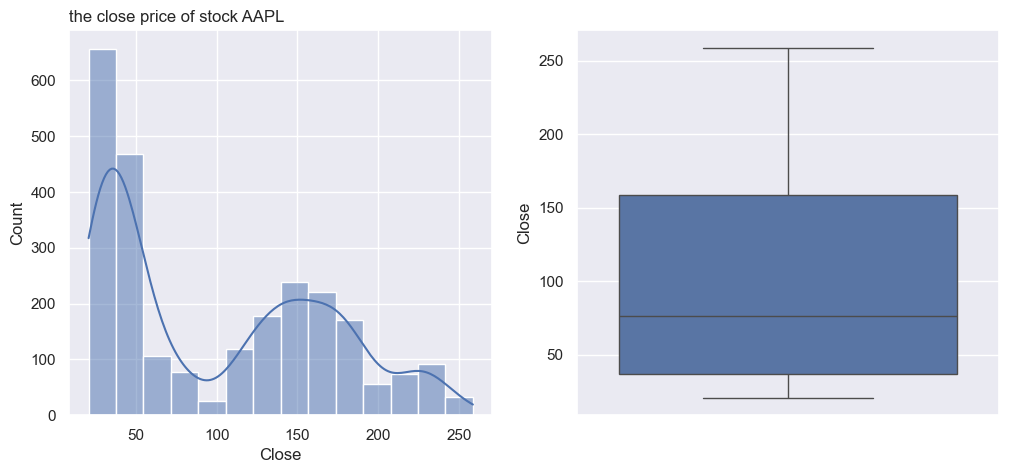

In [11]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title(f'the close price of stock {ticker_symbol}', loc ='left')
sns.histplot(data["Close"], kde=True)
plt.subplot(1,2,2)
sns.boxplot(data['Close'], orient='v')
plt.show()

In [12]:
from statsmodels.tsa.stattools import acf, pacf, q_stat, adfuller, grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [13]:
from scipy.stats import probplot, moment
# Hurst Exponent
def hurst(ts):
    lags = range(2, 100)
    tau = [np.sqrt(np.std(np.subtract(ts[lag:], ts[:-lag]))) for lag in lags]
    poly = np.polyfit(np.log(lags), np.log(tau), 1)
    return poly[0]*2.0

#define correlogram plot
def plot_correlogram(x,lags=None, title=None):
    lags = min(10, int(len(x)/5)) if lags is None else lags
    fig, axes = plt.subplots(nrows= 2, ncols = 2, figsize = (12,10))
    x.plot(ax = axes[0][0])
    q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
    stats = f'Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f} \nHurst: {round(hurst(x.values),2)}'
    axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)
    probplot(x, plot=axes[0][1])
    mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
    s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}'
    axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)
    plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0])
    plot_pacf(x, lags=lags, zero=False, ax=axes[1][1])
    axes[1][0].set_xlabel('Lag')
    axes[1][1].set_xlabel('Lag')
    fig.suptitle(title, fontsize=20)
    fig.tight_layout()
    fig.subplots_adjust(top=.9)

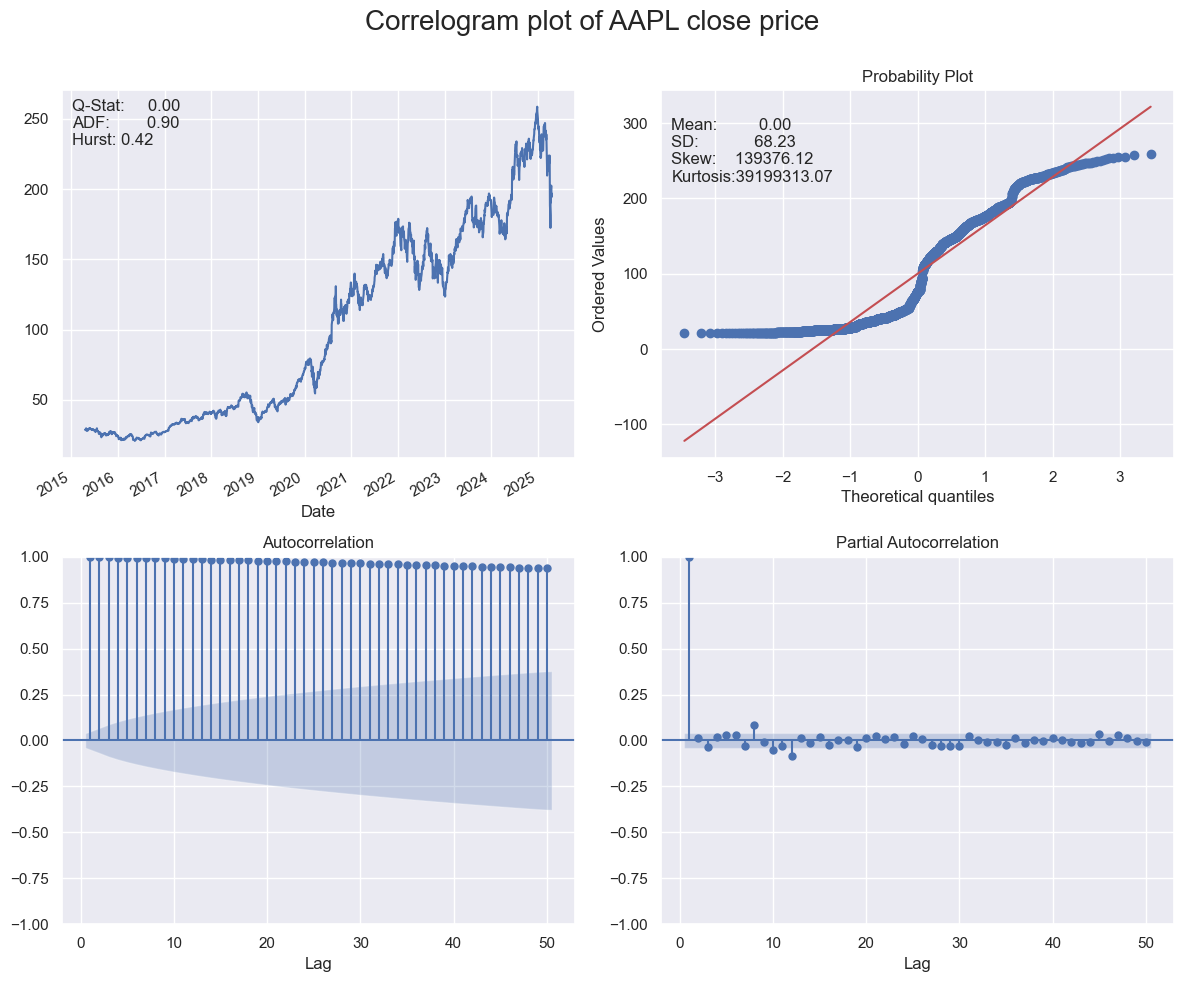

In [14]:
plot_correlogram(data['Close'], lags=50, title = f'Correlogram plot of {ticker_symbol} close price')

<Figure size 1500x1000 with 0 Axes>

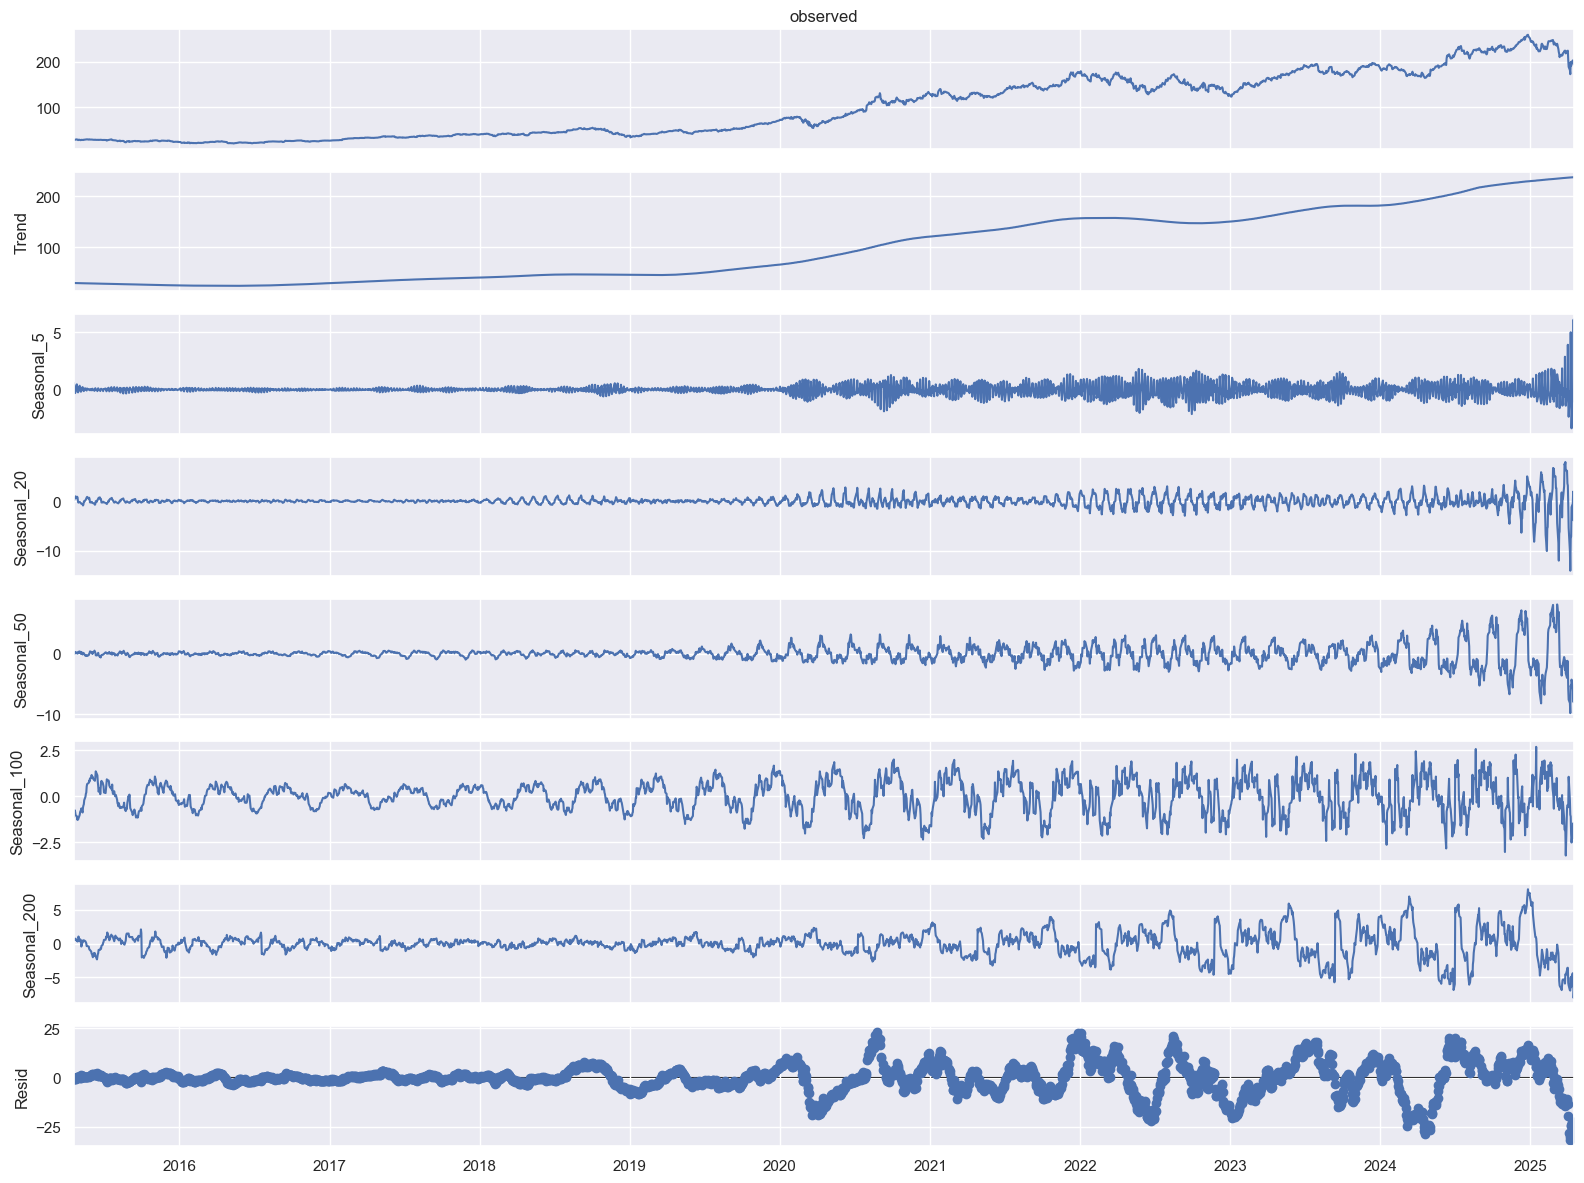

In [15]:
from statsmodels.tsa.seasonal import MSTL

plt.rc("figure", figsize=(16, 12))
plt.figure(figsize=(15,10))
# decomposited by 5,20,50,100,200-days
MSTL_result = MSTL(endog=data['Close'],  periods=(5, 20 ,50, 100, 200)).fit()

MSTL_result.plot()

plt.show()

Check any autocorrelation present in MSTL residual



In [16]:
ljungbox_test(MSTL_result.resid, [10, 15])

Ljung-Box test p-value for lag 10: 0.00000
Interpretation: Reject null hypothesis at lag 10: Significant autocorrelation present

Ljung-Box test p-value for lag 15: 0.00000
Interpretation: Reject null hypothesis at lag 15: Significant autocorrelation present



When the Ljung-Box test indicates significant autocorrelation, it means that the data points in the series are not randomly distributed. Instead, past values significantly influence future values, suggesting a pattern or trend in the data.

Tets for Stationary

In [17]:
result = adfuller(data['Close'], regression= 'ctt')
print('ADF Statistics %f %result[0]')
print('p-value: %f %result[1]')
print('Critical values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
if result[1] > 0.05:
    print('Fail to reject the null hypothesis (H0), data has a unit root and is stationary.')
else:
    print('Reject the null hypothese (H0), data does not have a unit root and is stationary')


ADF Statistics %f %result[0]
p-value: %f %result[1]
Critical values:
	1%: -4.376
	5%: -3.835
	10%: -3.555
Fail to reject the null hypothesis (H0), data has a unit root and is stationary.


If a time series is non-stationary but shows significant autocorrelation, it indicates that while the data has trends or varying means over time (non-stationarity), there are also patterns where past values are influencing future values (autocorrelation).

Non-stationary data often means that mean, variance, or other statistical properties change over time. This can result from trends, seasonality, or structural changes in the data. Autocorrelation in this context suggests these patterns are not purely random but have predictable influences over time.

Test for Nonlinearity

In [18]:
# Brock-Dechert-Scheinkman (BS) test

import statsmodels.api as sm
from statsmodels.tsa.tsatools import lagmat

#Function to perfrom BDS test
def bds_test(data, max_dim = 10):
    results = []
    for m in range(2, max_dim+1):
        transformed_data = lagmat(data, m, trim='both')
        residuals = np.diff(transformed_data, axis=1)
        test_result = sm.tsa.stattools.bds(residuals[:,-1])
        results.append(test_result)
    return results

#print function for BDS test result
def print_bds_results(results):
    for i, result in enumerate(results):
        m = i+2
        test_statistic, p_value, *_ = result
        print(f"Dimension m = {m}:")
        print(f" Test Statistic: {test_statistic: .4f}")
        print(f" p-value: {p_value: .4f}")
        if p_value < 0.05:
            print(" Result: Reject the null hypothesis (Nonlinesr dependencies detected)")
        else:
            print("Result: Fail to reject the null hypothesis (Likely linear I.i.d)")
        print(" ")


#perform BDS test
bds_results = bds_test(data['Close'])

#Print the result
print_bds_results(bds_results)




Dimension m = 2:
 Test Statistic:  15.6090
 p-value:  0.0000
 Result: Reject the null hypothesis (Nonlinesr dependencies detected)
 
Dimension m = 3:
 Test Statistic:  15.4341
 p-value:  0.0000
 Result: Reject the null hypothesis (Nonlinesr dependencies detected)
 
Dimension m = 4:
 Test Statistic:  15.6901
 p-value:  0.0000
 Result: Reject the null hypothesis (Nonlinesr dependencies detected)
 
Dimension m = 5:
 Test Statistic:  15.5888
 p-value:  0.0000
 Result: Reject the null hypothesis (Nonlinesr dependencies detected)
 
Dimension m = 6:
 Test Statistic:  15.4083
 p-value:  0.0000
 Result: Reject the null hypothesis (Nonlinesr dependencies detected)
 
Dimension m = 7:
 Test Statistic:  15.2458
 p-value:  0.0000
 Result: Reject the null hypothesis (Nonlinesr dependencies detected)
 
Dimension m = 8:
 Test Statistic:  15.1941
 p-value:  0.0000
 Result: Reject the null hypothesis (Nonlinesr dependencies detected)
 
Dimension m = 9:
 Test Statistic:  15.0271
 p-value:  0.0000
 Result:

Text(0, 0.5, 'Magnitude')

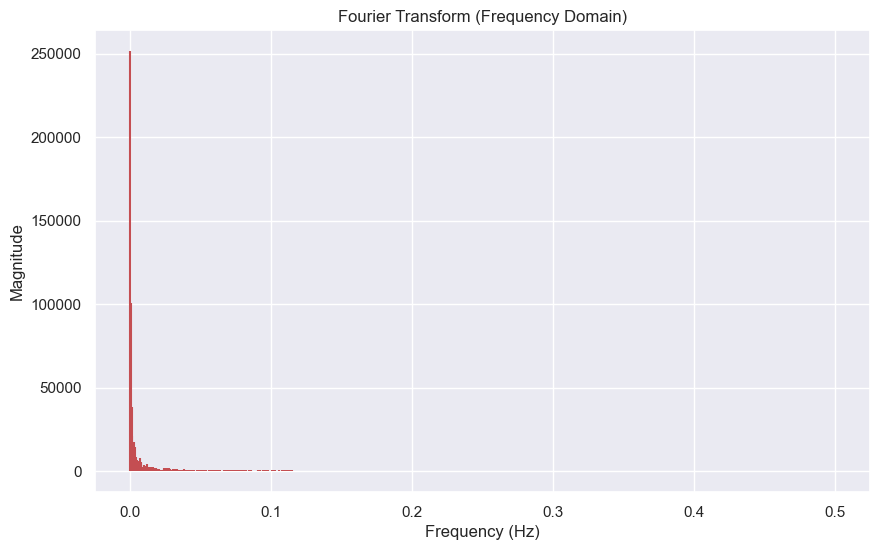

In [20]:
# Check seasonal cycle using Spectral Analysis (Fourier Transform)

freqs = np.fft.fftfreq(len(data['Close']))
magn =  np.abs(np.fft.fft(data['Close']))
plt.figure(figsize=(10, 6))
plt.stem(freqs[:len(freqs)//2], 
           magn[:len(magn)//2], 
           linefmt='r', markerfmt=" ", basefmt=" ")


plt.title("Fourier Transform (Frequency Domain)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
#plt.show()

# Save the figure
#plt.savefig('fft.jpg')

In [21]:
import pywt

In [22]:
def recommend_levels(signal_length):
    """
    Recommend maximum decomposition level
    """
    return pywt.dwt_max_level(signal_length, 'db6')

# Example
signal_length = len(data['Close'])
max_level = recommend_levels(signal_length)
print(f"Recommended maximum level: {max_level}")

Recommended maximum level: 7


/var/folders/dw/c3ntnt1x4kn59s38pldw62hr0000gn/T/ipykernel_86003/231497187.py:17: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



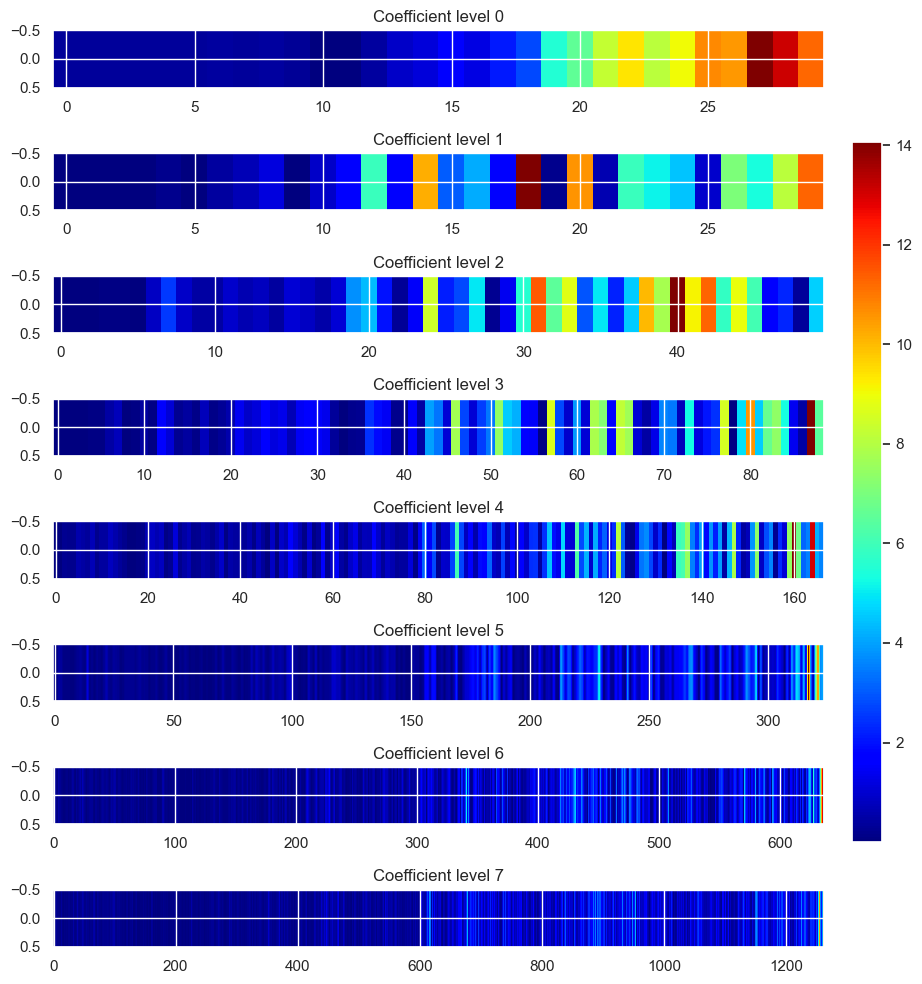

In [23]:
# Perform the Discrete Wavelet Transform with 'dbN'
wavelet = pywt.Wavelet('db6')
coeffs = pywt.wavedec(data['Close'], wavelet, level=7)

# Plotting the Wavelet Coefficients using imshow
fig, axes = plt.subplots(len(coeffs), 1, figsize=(10, 10))

for i, ax in enumerate(axes):
    im = ax.imshow(np.abs(coeffs[i].reshape(1, -1)), aspect='auto', cmap='jet')
    ax.set_title(f'Coefficient level {i}')

# Add a single colorbar on the far right
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.86, 0.15, 0.03, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.tight_layout(rect=[0, 0, 0.85, 1])
#plt.show()

# Save the figure
#plt.savefig('db6.jpg')

Wavelet db6
  Family name:    Daubechies
  Short name:     db
  Filters length: 12
  Orthogonal:     True
  Biorthogonal:   True
  Symmetry:       asymmetric
  DWT:            True
  CWT:            False


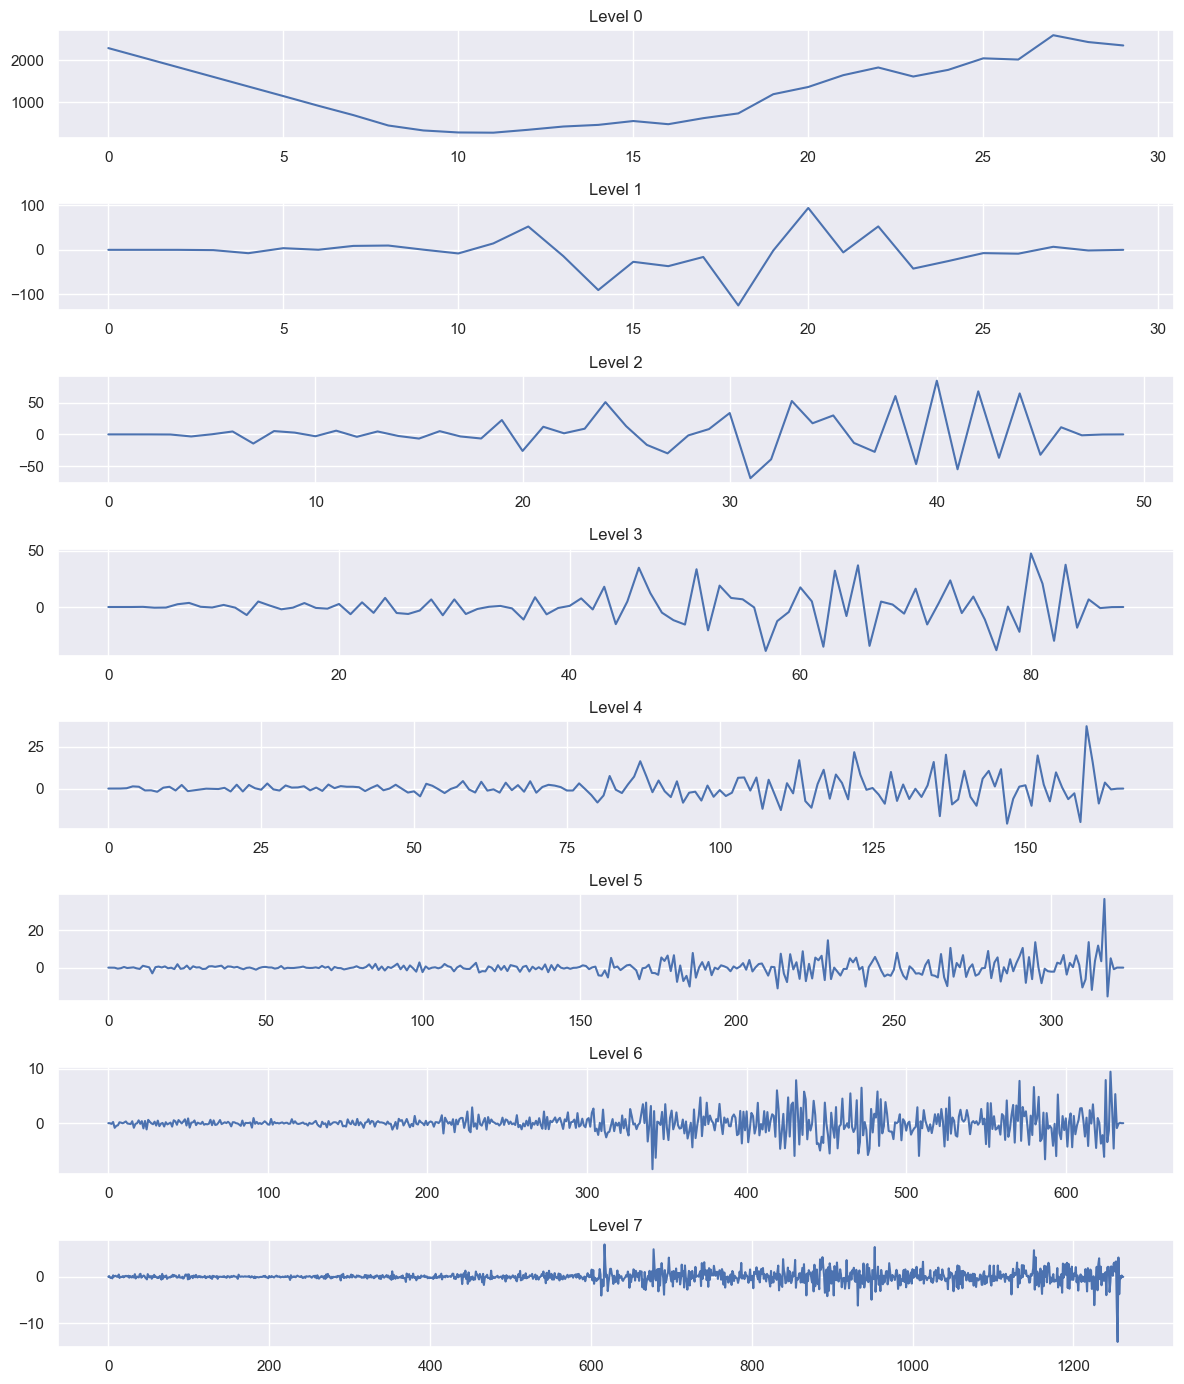

In [24]:

# Choose Symlets ('symN') of decomposition
wavelet = pywt.Wavelet('db6')
print(wavelet)
level = 7

# Perform wavelet decomposition
# mode – Signal extension mode to deal with signal edge during the transform
# level – Number of decomposition steps to perform
coeffs = pywt.wavedec(data['Close'], wavelet, level=level, mode='smooth')

# Plot the coefficients
plt.figure(figsize=(12, 14))
for i, coeff in enumerate(coeffs):
    plt.subplot(level + 1, 1, i + 1)
    plt.plot(coeff)
    plt.title(f'Level {i}')
plt.tight_layout()
plt.show()

Define Bi-directional LSTM Model

In [25]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional,  Flatten, RepeatVector,Input
from tensorflow.keras.callbacks import EarlyStopping

In [26]:
#copying the data
df = data.copy()

In [27]:
#Applying wavelet transform

wavelet = pywt.Wavelet('db6')

def wavelet_transform(data, lvl = 7):
    coeff = pywt.wavedec(data, wavelet, mode='symmetric', level=lvl)
    return coeff

#Inverse wavelet transform

def inverse_wavelet_transform(coeff):
    #remove last 3 finer details
    for i in range(3):
        coeffs[i+5] = np.zeros(coeffs[i+5].shape)
    return pywt.waverec(coeff, wavelet, mode='symmetric')


In [28]:
#Prepare the data
close_price = df['Close'].values
wavelet_coeff = wavelet_transform(close_price)
reconstructed_data = inverse_wavelet_transform(wavelet_coeff)

In [29]:
print(reconstructed_data.shape)
print(reconstructed_data)

(2516,)
[ 28.5   28.34  28.72 ... 202.14 194.27 196.98]


In [30]:
#Normalize data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(reconstructed_data.reshape(-1,1))

In [31]:
#create sequence for LSTM
def create_seqences(data, seq_length):
    X, y = [], []
    for i in range(len(data)- seq_length):
        X.append(data[i: i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 20

X,y = create_seqences(scaled_data, seq_length)



In [32]:
#split data into training and testing
split = int(0.8*len(X))
X_train , y_train = X[:split], y[:split]
X_test, y_test = X[split:], y[split:]

In [33]:
#Build LSTM Model
model = Sequential([
    Input(shape=(seq_length,1)),
    Bidirectional(LSTM(units=256, return_sequences=True)),
    Dropout(0.3),
    Bidirectional(LSTM(units=128, return_sequences=True)),
    Dropout(0.3),
    #RepeatVector(seq_length),
    Bidirectional(LSTM(units=64, return_sequences=False)),
    Dropout(0.2),
    Dense(units=64, activation='relu'),
    Dense(units=32),
    Flatten(),
    Dense(units=1) 
])

In [34]:
import keras

In [35]:
#lr_schedule = keras.optimizers.schedules.ExponentialDecay(
  #  initial_learning_rate=1e-2,
   # decay_steps=10000,
   # decay_rate=0.9)
#opt = keras.optimizers.Adam(learning_rate=lr_schedule)

#opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile( optimizer='adam', loss='mean_squared_error', metrics=['mae'])

#Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

#Train model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 95ms/step - loss: 0.0078 - mae: 0.0543 - val_loss: 0.0041 - val_mae: 0.0571
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 108ms/step - loss: 5.2267e-04 - mae: 0.0159 - val_loss: 8.8773e-04 - val_mae: 0.0248
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 154ms/step - loss: 3.9746e-04 - mae: 0.0126 - val_loss: 0.0051 - val_mae: 0.0654
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 144ms/step - loss: 3.8904e-04 - mae: 0.0125 - val_loss: 0.0012 - val_mae: 0.0279
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - loss: 3.9315e-04 - mae: 0.0128 - val_loss: 0.0016 - val_mae: 0.0327
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 140ms/step - loss: 4.3143e-04 - mae: 0.0148 - val_loss: 0.0026 - val_mae: 0.0442
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step - loss: 2.9897e-04 - mae: 0.0110 - val_loss: 0.0029 - val_mae: 0.0477
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - loss: 3.1991e-04 - mae: 0.0111 - val_loss: 0.0014 - val_mae: 0.0313
Epoch 9/100
50/50

In [36]:
#Make predictions
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step


In [37]:
#Inverse transform predictions
train_predictions = scaler.inverse_transform(train_predictions)
test_predictions = scaler.inverse_transform(test_predictions)
y_train = scaler.inverse_transform(y_train.reshape(-1,1))
y_test = scaler.inverse_transform(y_test.reshape(-1,1))



In [38]:
#calculate error metrics
train_mae = mean_absolute_error(y_train, train_predictions)
train_mse = mean_squared_error(y_train, train_predictions)
train_rmse = np.sqrt(train_mse)
train_mape = mean_absolute_percentage_error(y_train, train_predictions)
train_r2 = r2_score(y_train, train_predictions)

test_mae = mean_absolute_error(y_test, test_predictions)
test_mse = mean_squared_error(y_test, test_predictions)
test_rmse = np.sqrt(test_mse)
test_mape = mean_absolute_percentage_error(y_test, test_predictions)
test_r2 = r2_score(y_test, test_predictions)

metric_data = {
    "Metric": ["MAE", "MSE", "RMSE", "MAPE", "R2"],
    "Train": [train_mae, train_mse, train_rmse, train_mape, train_r2],
    "Test": [test_mae, test_mse, test_rmse, test_mape, test_r2] }

metric_df = pd.DataFrame(metric_data)
print(metric_df)

  Metric     Train       Test
0    MAE  1.747291   7.867238
1    MSE  7.337155  96.905069
2   RMSE  2.708718   9.844037
3   MAPE  0.023447   0.036996
4     R2  0.997110   0.850769


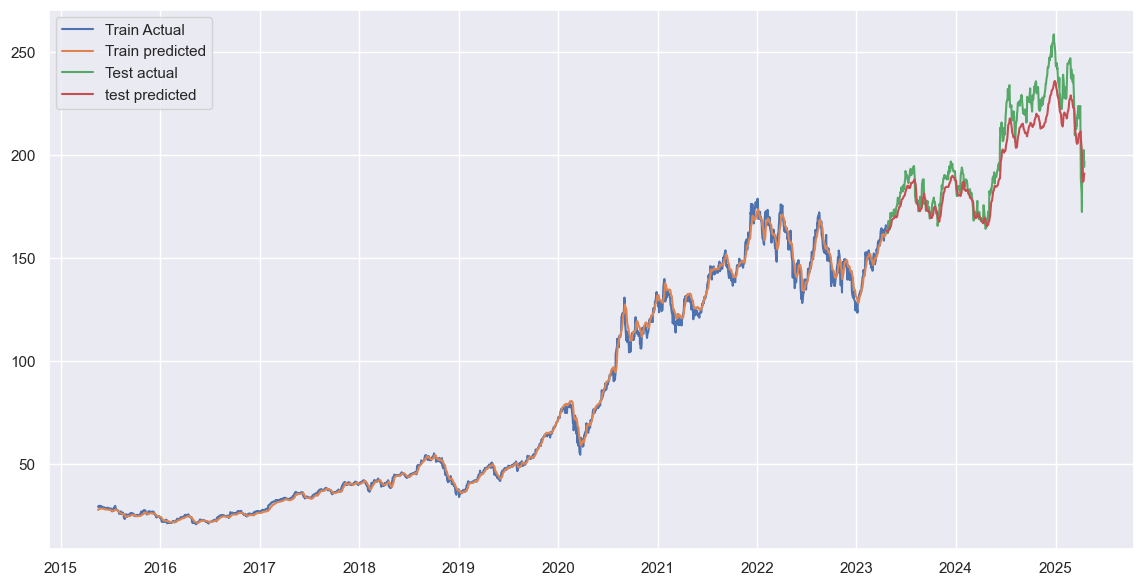

In [39]:
#Visulaize the result
plt.figure(figsize = (14,7))
plt.plot(df.index[seq_length:split+seq_length], y_train, label='Train Actual')
plt.plot(df.index[seq_length:split+seq_length], train_predictions, label='Train predicted')
plt.plot(df.index[split+seq_length:], y_test, label='Test actual')
plt.plot(df.index[split+seq_length:], test_predictions, label='test predicted')
plt.legend()
plt.show()


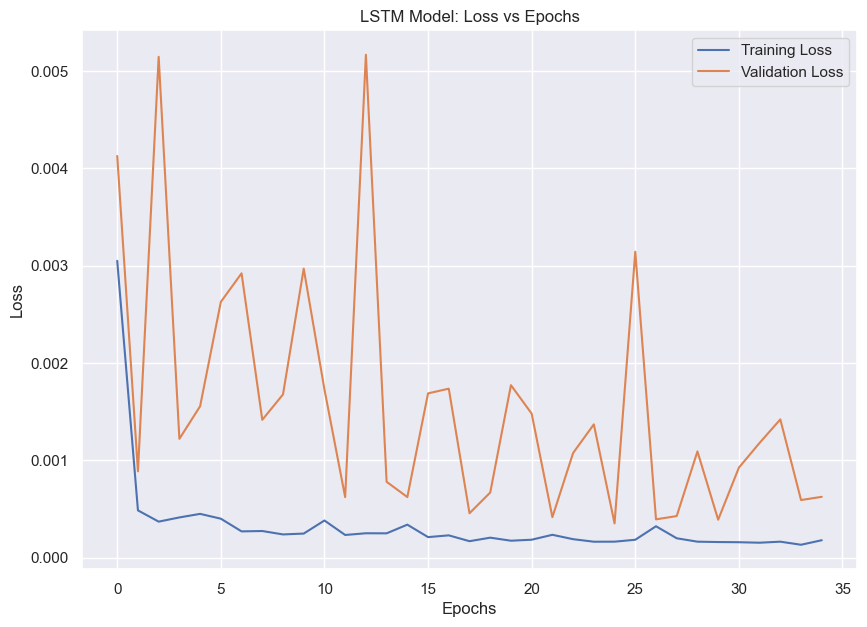

In [40]:
#Plotting Loss vs Epoch
plt.figure(figsize=(10,7))
#Plot training loss
plt.plot(history.history['loss'], label='Training Loss')
#If you have validation loss, you can plot it as well
plt.plot(history.history['val_loss'], label ='Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('LSTM Model: Loss vs Epochs')
plt.legend()

plt.show()

In [41]:
df_index = pd.DataFrame(data['Close'].iloc[-y_test.shape[0]:].copy()).index
y_test_df = pd.DataFrame(y_test, columns=['y_test'], index=df_index)
predict_value_df = pd.DataFrame(test_predictions, columns=['predict_values'], index=df_index)

#concatenate along the columns
combined_df = pd.concat([y_test_df, predict_value_df], axis =1)
combined_df

,y_test,predict_values
Date,,
2023-04-21,163.37,163.238678
2023-04-24,163.68,163.281830
2023-04-25,162.13,163.267258
2023-04-26,162.12,162.943848
2023-04-27,166.73,162.606888
...,...,...
2025-04-11,198.15,187.023895
2025-04-14,202.52,187.475555
2025-04-15,202.14,189.136826


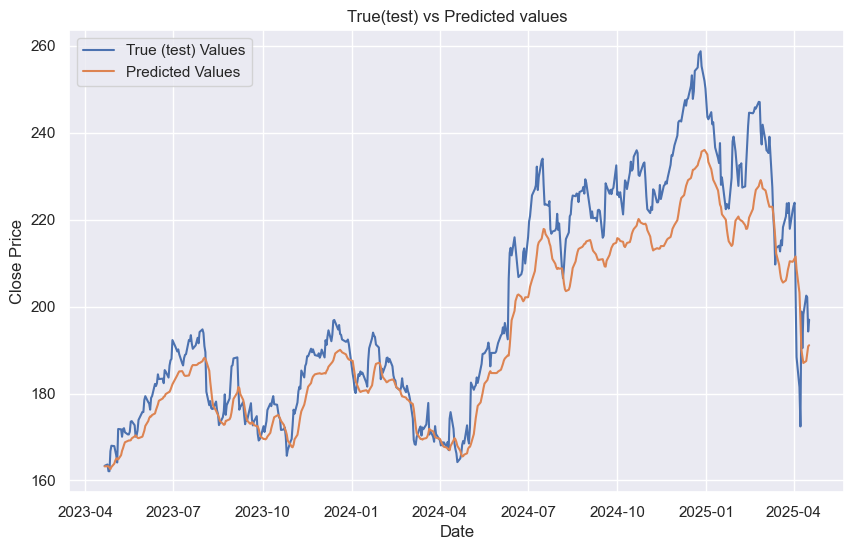

In [42]:
#Plotting true vs predicted values
plt.figure(figsize=(10,6))
plt.plot(combined_df.index, combined_df['y_test'], label = 'True (test) Values')
plt.plot(combined_df.index, combined_df['predict_values'], label='Predicted Values')

plt.xlabel("Date")
plt.ylabel('Close Price')
plt.title('True(test) vs Predicted values')
plt.legend()
plt.show()

